# Creating Benchmark Models as a Baseline

## Since our Problem did not have any exact existing implementations, we have to create our own Benchmarks, as stated in the approved Capstone Proposal

## To Create some Benchmark Models, we tried 2 approaches:

### 1. Creating our own CNN Architecture and training it from scratch with our Data
### 2. Using a Pre-Trained Model and Fine-Tuning it with our Data

## This Notebook contains the code to create & run the Model Estimators. 

### `CNN_model_train_benchmark.py` contains the code where we create our custom CNN Architecture along with training and evaluating it
### `Resnet_model_train_benchmark.py` contains the code where we finetune a Resnet 50 Architecture along with training and evaluating it

### NOTE: The details about Data Loaders and Transformations are in `Final_Model_Train_Inference.ipynb`. We use identical Data Loaders and their transformations here

### NOTE: Due to Limitations and Constraints of AWS Resources, the training for Benchmarks hasn't been very intense, since the aim of the project was for learning good MLE Principles with SageMaker and not maximising accuracy

In [4]:
%%capture
!pip install smdebug torch torchvision tqdm

In [5]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
from smdebug import modes
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import IPython

## Benchmark Model I: Custom CNN Architecture

### Hyper Parameters: Batch Size 32 and Learning Rate: 0.005 Epochs = 5
### Training on a ml.p3.2xlarge GPU Instance

In [27]:
hyperparameters = {"batch_size": 32, \
                   "learning_rate": "0.005"}
hyperparameters

{'batch_size': 32, 'learning_rate': '0.005'}

In [28]:
role = sagemaker.get_execution_role()

In [29]:
estimator = PyTorch(
    entry_point='CNN_model_train_benchmark.py',
    base_job_name='benchmark-bins',
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
)

In [30]:
os.environ['SM_CHANNEL_TRAINING']='s3://sagemaker-studio-0qajs6acpsz/BinDataset/'
os.environ['SM_MODEL_DIR']='s3://sagemaker-studio-0qajs6acpsz/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://sagemaker-studio-0qajs6acpsz/output/'
estimator.fit({"training": "s3://sagemaker-studio-0qajs6acpsz/BinDataset/"}, wait=False)

## Results 

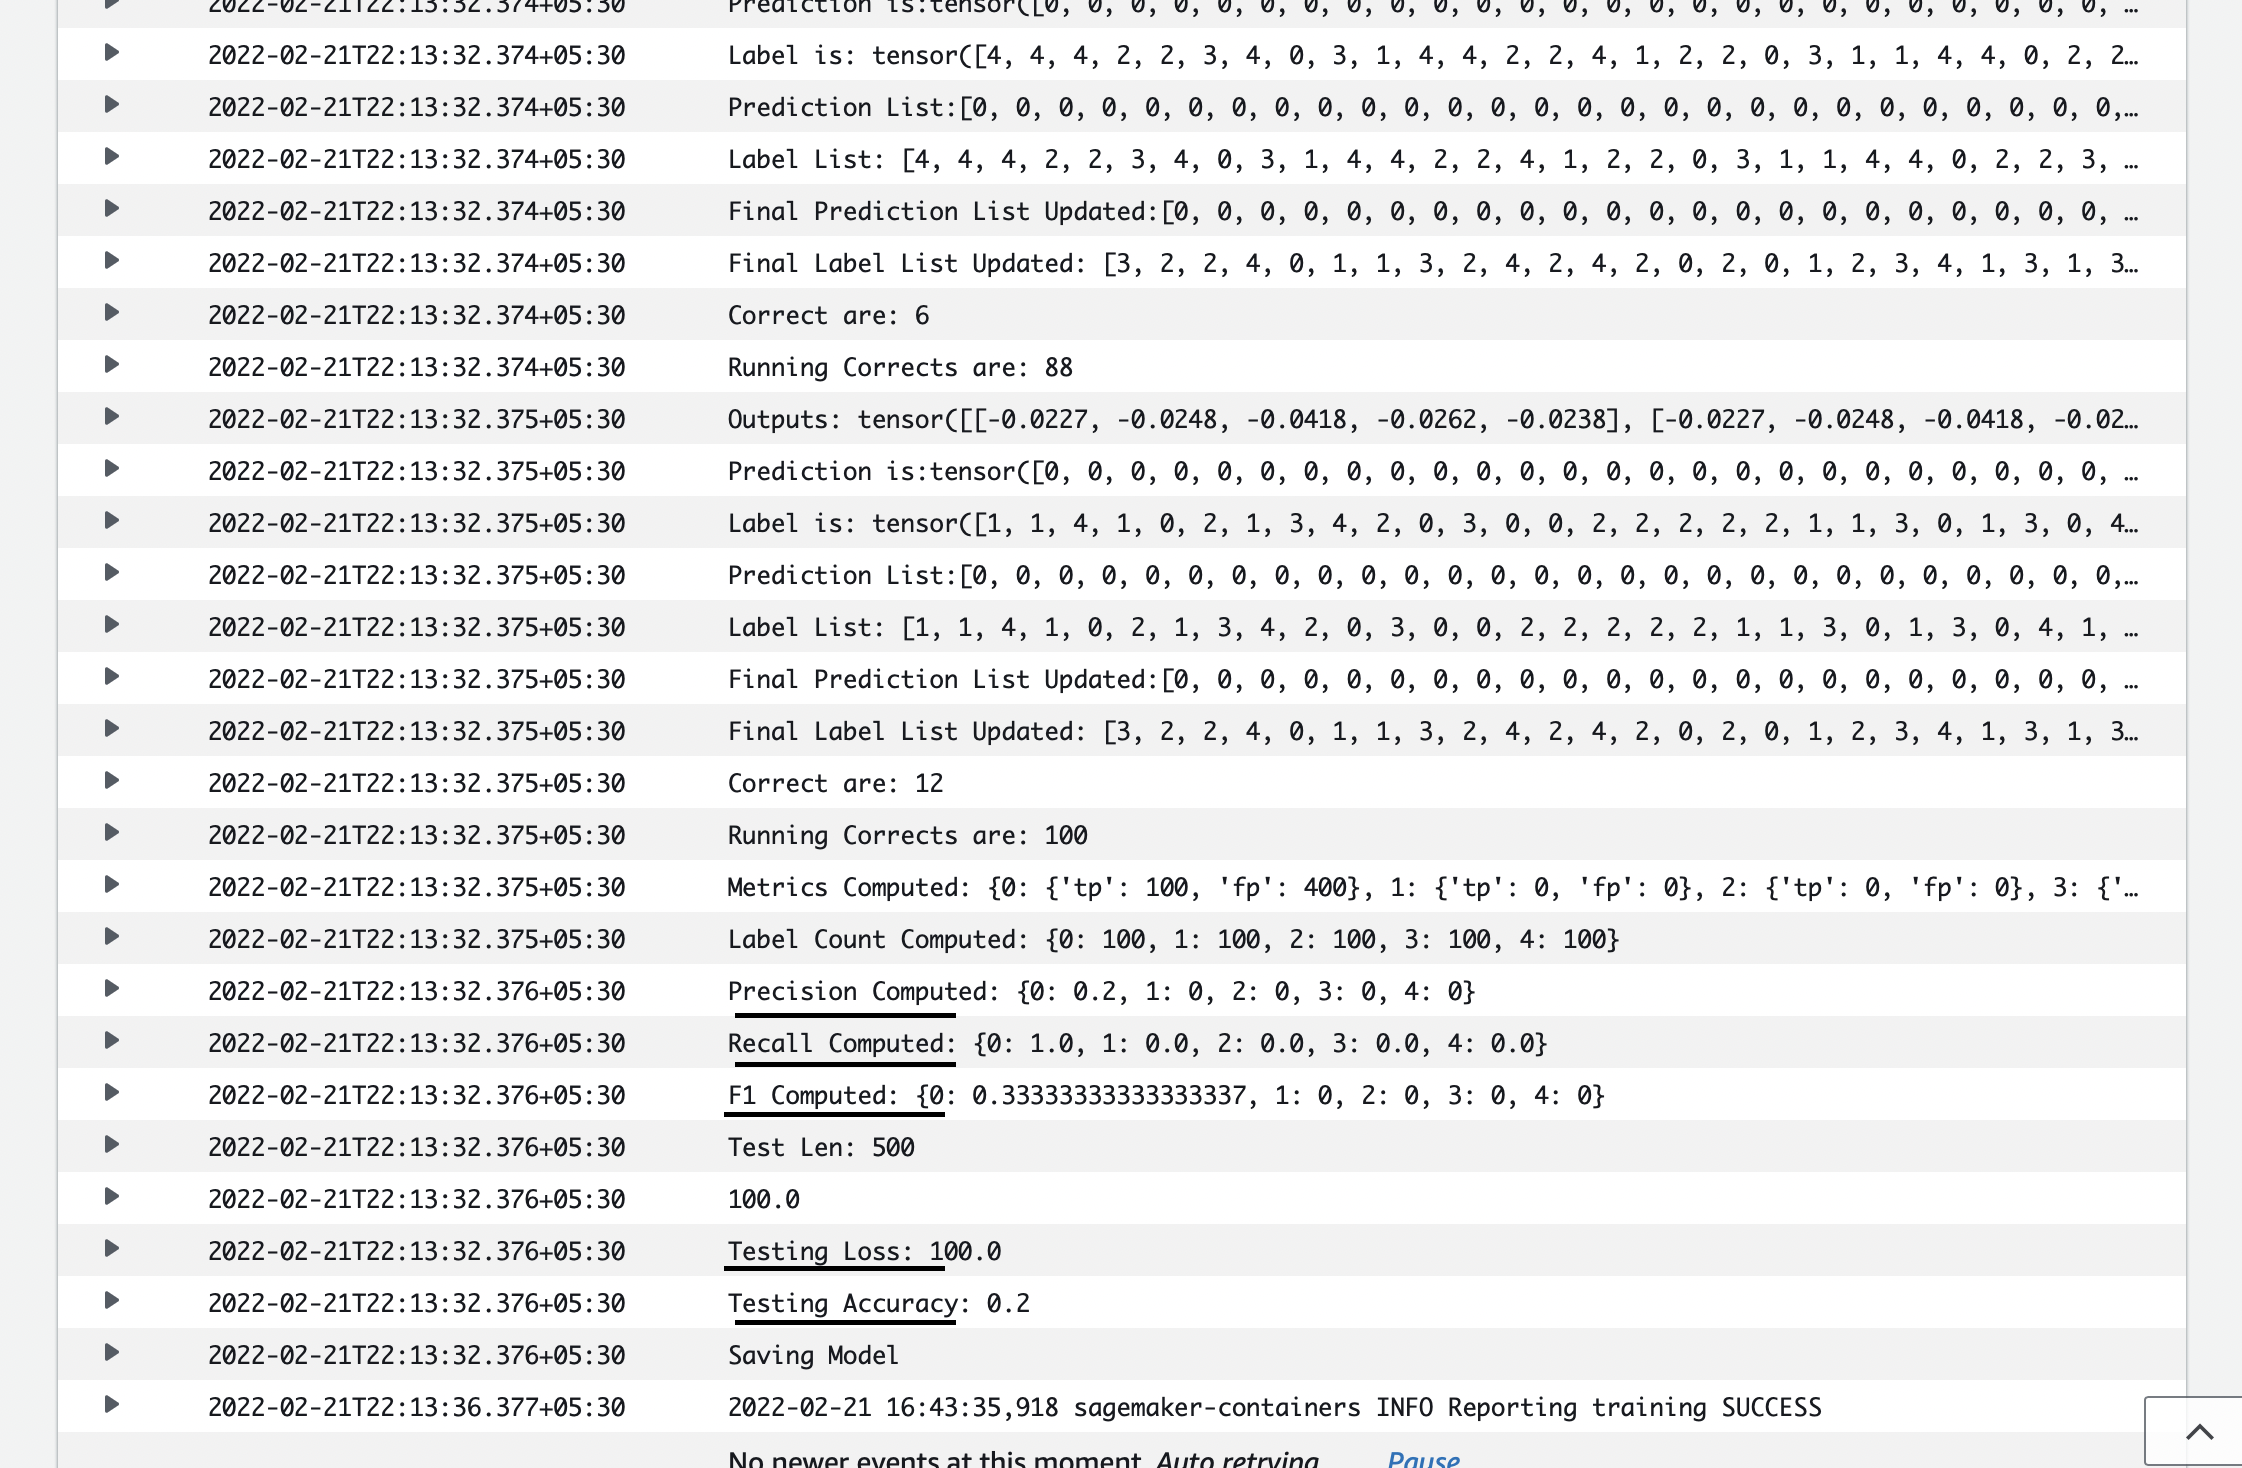

### Class Wise Metrics

| **Class** | **Precision** | **Recall** | **F1 Score** |
|-----------|---------------|------------|--------------|
| **1**     | 0.2           | 1          | 0.33         |
| **2**     | 0             | 0          | 0            |
| **3**     | 0             | 0          | 0            |
| **4**     | 0             | 0          | 0            |
| **5**     | 0             | 0          | 0            |

#### Overall Test Set Accuracy = 0.2 (20%)

### We see that the CNN wasn't able to learn very well, and ends up only predicting Class 1, which results in a non-optimal F1 Score for all classes

### Since we had a constraint on resources, training a CNN Architecture from Scratch and achieving good performance is difficult, and using a bigger CNN resulted in an out of memory error, so this is the best Benchmark with a custom CNN architecture from scratch. 

### Thus, we also explore using a Pre-trained Model as a second Benchmark

---------------------

## Benchmark Model II: Pre-Trained Resnet50 Finetuning

### Hyper Parameters: Batch Size 64 and Learning Rate: 0.001 Epochs = 5
### Training on a ml.p3.2xlarge GPU Instance

In [1]:
hyperparameters = {"batch_size": 64, \
                   "learning_rate": "0.001"}
hyperparameters

{'batch_size': 64, 'learning_rate': '0.001'}

In [28]:
role = sagemaker.get_execution_role()

In [29]:
estimator = PyTorch(
    entry_point='Resnet_model_train_benchmark.py',
    base_job_name='benchmark-bins',
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
)

In [30]:
os.environ['SM_CHANNEL_TRAINING']='s3://sagemaker-studio-0qajs6acpsz/BinDataset/'
os.environ['SM_MODEL_DIR']='s3://sagemaker-studio-0qajs6acpsz/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://sagemaker-studio-0qajs6acpsz/output/'
estimator.fit({"training": "s3://sagemaker-studio-0qajs6acpsz/BinDataset/"}, wait=False)

## Results

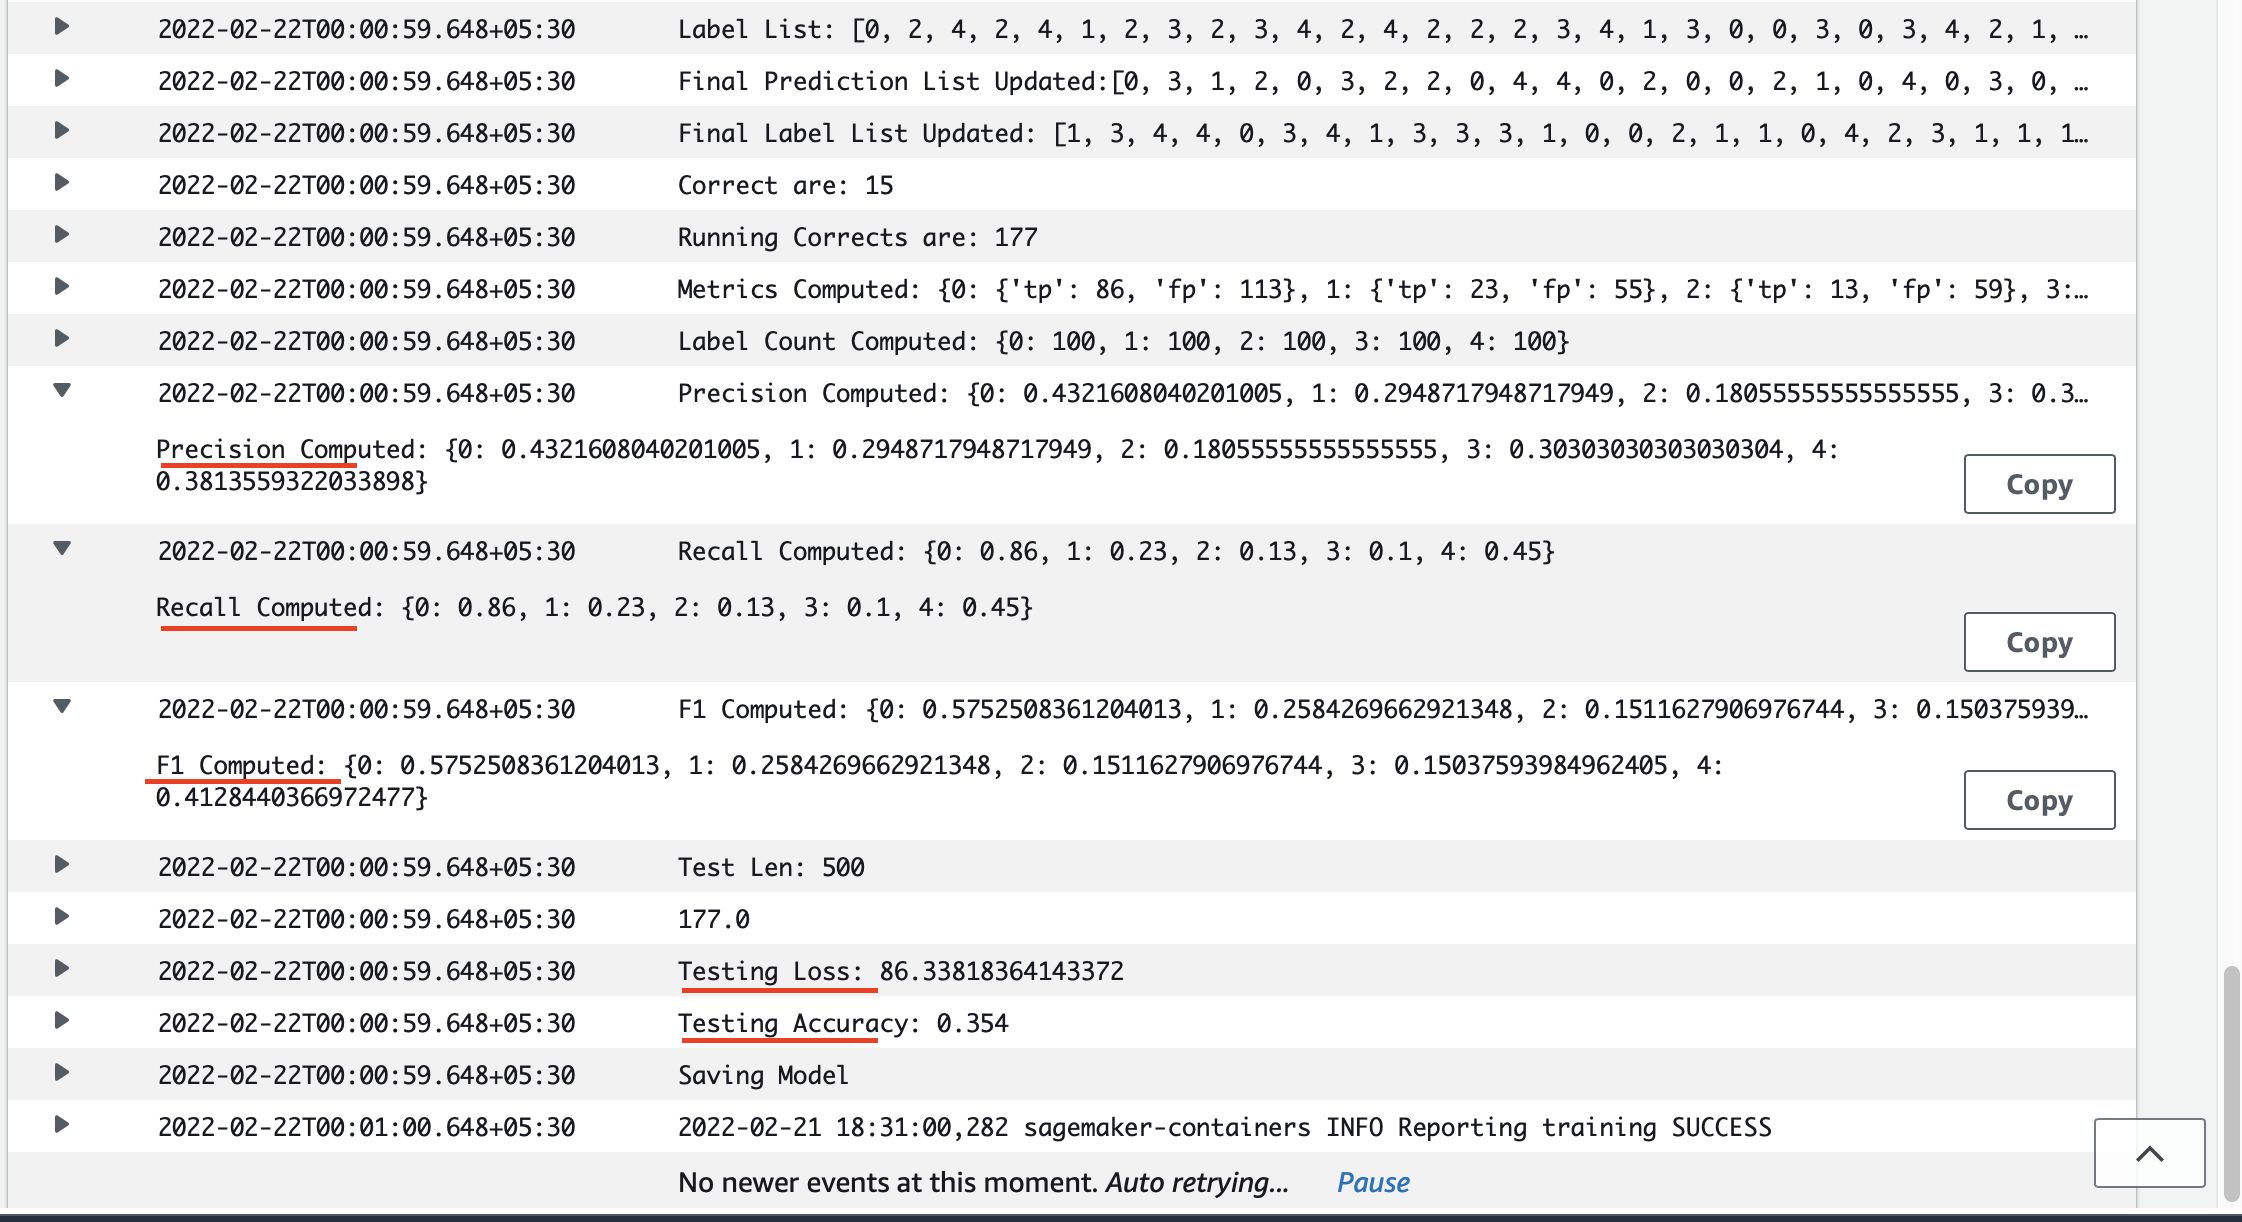

### Class Wise Metrics
| **Class** | **Precision** | **Recall** | **F1 Score** |
|-----------|---------------|------------|--------------|
| **1**     | 0.432         | 0.86       | 0.575        |
| **2**     | 0.294         | 0.23       | 0.258        |
| **3**     | 0.180         | 0.13       | 0.151        |
| **4**     | 0.303         | 0.1        | 0.150        |
| **5**     | 0.381         | 0.45       | 0.412        |

#### Overall Test Set Accuracy = 0.354 (35.4%)

### We see that the pre-trained model results in a much better Benchmark!

### Since we had a constraint on resources, we haven't pushed the training, but this can act as a good enough baseline for us to beat!



---------------------

## So we now have our Benchmarks ready!